## 1. Loading necessary libraries

In [5]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings = warnings

In [141]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.modelling_pipeline as models
reload(models)

mp = models.ModelPipeline(ROOT_DIR)

# import nbimporter
# import src.modelling_pipeline as modelling
# #reload(modelling)

In [7]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

## 2. Loading Data

In [8]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

Removed 8210 admissions with AGE < 18


In [9]:
columns = ["SUBJECT_ID", "HADM_ID"]
num_unique_combinations = df_demographic.drop_duplicates(subset=columns).shape[0]

print("Number of unique combinations (>18 years old):")
print(num_unique_combinations)

Number of unique combinations (>18 years old):
50766


## 3. Dataset Extraction

In [10]:
hours_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
top_n_features = [10, 20, 30, 40]

In [11]:
dfs_dict = {}
for top_n in top_n_features:
  dfs_dict[f'top{top_n}'] = {}
  for hour in hours_list:
    feature_filename=ROOT_DIR / 'data/potential_events.csv'
    output_filename = ROOT_DIR / f'data/full_data/t{hour}_top{top_n}.csv'
    dfs_dict[f'top{top_n}'][f't{hour}']=dataLoader.extract_full_data_by_features(df_labevents, df_demographic, df_desc_labitems, hour, feature_filename, top_n, output_filename)


In [21]:
dfs_dict['top40']['t3']

SUBJECT_ID  HADM_ID  AGE  IS_SEPSIS  GENDER_NUM  ITEMID_50804  \
0              22   165315   64          0           1          22.0   
1              23   152223   71          0           0          24.0   
2              23   124321   75          0           0        -999.0   
3              24   161859   39          0           0          27.0   
4              25   129635   58          0           0        -999.0   
...           ...      ...  ...        ...         ...           ...   
50674       98794   190603   78          0           0          21.0   
50675       98797   105447   88          1           0          33.0   
50676       98800   191113   19          0           1          25.0   
50677       98802   101071   83          0           1          18.0   
50678       98805   122631   42          0           0          27.0   

       ITEMID_50809  ITEMID_50813  ITEMID_50818  ITEMID_50820  ...  \
0            -999.0        -999.0          29.0          7.47  ...   
1             112.0        -999.0          34.0          7.45  ...   
2            -999.0        -999.0        -999.0       -999.00  ...   
3            -999.0        -999.0          40.0          7.42  ...   
4            -999.0        -999.0        -999.0       -999.00  ...   
...             ...           ...           ...           ...  ...   
50674         150.0           1.8          30.0          7.44  ...   
50675         163.0           2.6          61.0          7.32  ...   
50676          99.0        -999.0          53.0          7.27  ...   
50677         258.0           3.5          24.0          7.47  ...   
50678         123.0           2.2          53.0          7.29  ...   

       ITEMID_51250  ITEMID_51256  ITEMID_51265  ITEMID_51274  ITEMID_51275  \
0              90.0          62.2         259.0          12.4          30.1   
1            -999.0        -999.0        -999.0        -999.0        -999.0   
2            -999.0        -999.0        -999.0        -999.0        -999.0   
3            -999.0        -999.0        -999.0        -999.0        -999.0   
4              91.0          84.6         269.0          12.8          34.6   
...             ...           ...           ...           ...           ...   
50674        -999.0        -999.0         226.0          15.3          31.2   
50675          87.0        -999.0         184.0          24.1          33.6   
50676          93.0          89.4         151.0          14.3          28.7   
50677          84.0        -999.0         271.0          11.8          23.7   
50678        -999.0        -999.0        -999.0        -999.0        -999.0   

       ITEMID_51277  ITEMID_51279  ITEMID_51301  ITEMID_51493  SOFA  
0              12.6          4.00           5.1           0.0     2  
1            -999.0       -999.00        -999.0        -999.0  -999  
2            -999.0       -999.00        -999.0        -999.0  -999  
3            -999.0       -999.00        -999.0        -999.0  -999  
4              13.0          4.17          12.2        -999.0  -999  
...             ...           ...           ...           ...   ...  
50674        -999.0       -999.00        -999.0        -999.0  -999  
50675          15.8          3.41           6.2        -999.0  -999  
50676          12.7          3.15          15.1        -999.0  -999  
50677          14.1          5.03          30.3        -999.0  -999  
50678        -999.0       -999.00        -999.0        -999.0  -999  

[50679 rows x 46 columns]

## 4. Data processing

### 4.1 Missing values

In [13]:
mp.count_missing_values(dfs_dict['top10'])

Number of missing values in t0: 337938 (39.19%)
Number of missing values in t1: 281873 (32.70%)
Number of missing values in t2: 252276 (29.27%)
Number of missing values in t3: 229446 (26.63%)
Number of missing values in t4: 209346 (24.31%)
Number of missing values in t5: 191785 (22.28%)
Number of missing values in t6: 177380 (20.63%)
Number of missing values in t7: 165824 (19.31%)
Number of missing values in t8: 156133 (18.21%)


In [14]:
mp.count_missing_values(dfs_dict['top20'])

Number of missing values in t0: 655171 (49.68%)
Number of missing values in t1: 552885 (41.93%)
Number of missing values in t2: 501521 (38.05%)
Number of missing values in t3: 461332 (35.01%)
Number of missing values in t4: 425678 (32.32%)
Number of missing values in t5: 393840 (29.92%)
Number of missing values in t6: 366778 (27.89%)
Number of missing values in t7: 344198 (26.21%)
Number of missing values in t8: 325172 (24.80%)


In [15]:
mp.count_missing_values(dfs_dict['top30'])

Number of missing values in t0: 1022882 (56.02%)
Number of missing values in t1: 881229 (48.27%)
Number of missing values in t2: 808140 (44.28%)
Number of missing values in t3: 751050 (41.17%)
Number of missing values in t4: 701282 (38.46%)
Number of missing values in t5: 657403 (36.07%)
Number of missing values in t6: 620056 (34.05%)
Number of missing values in t7: 588585 (32.37%)
Number of missing values in t8: 561948 (30.95%)


In [16]:
mp.count_missing_values(dfs_dict['top40'])

Number of missing values in t0: 1368814 (59.97%)
Number of missing values in t1: 1194105 (52.33%)
Number of missing values in t2: 1104934 (48.43%)
Number of missing values in t3: 1035111 (45.39%)
Number of missing values in t4: 974102 (42.74%)
Number of missing values in t5: 920375 (40.40%)
Number of missing values in t6: 874361 (38.42%)
Number of missing values in t7: 835039 (36.74%)
Number of missing values in t8: 801458 (35.32%)


In [18]:
mp.count_missing_SOFA(dfs_dict['top20'])

Number of missing SOFA in t0: 39568 (78.02%)
Number of missing SOFA in t1: 36742 (72.45%)
Number of missing SOFA in t2: 35110 (69.25%)
Number of missing SOFA in t3: 33783 (66.66%)
Number of missing SOFA in t4: 32728 (64.62%)
Number of missing SOFA in t5: 31871 (62.96%)
Number of missing SOFA in t6: 31045 (61.38%)
Number of missing SOFA in t7: 30262 (59.92%)
Number of missing SOFA in t8: 29525 (58.55%)


In [19]:
mp.count_missing_SOFA(dfs_dict['top30'])

Number of missing SOFA in t0: 39568 (78.02%)
Number of missing SOFA in t1: 36742 (72.45%)
Number of missing SOFA in t2: 35110 (69.25%)
Number of missing SOFA in t3: 33783 (66.66%)
Number of missing SOFA in t4: 32728 (64.62%)
Number of missing SOFA in t5: 31871 (62.96%)
Number of missing SOFA in t6: 31045 (61.38%)
Number of missing SOFA in t7: 30262 (59.92%)
Number of missing SOFA in t8: 29525 (58.55%)


In [25]:
# Remove admissions with >70% missing values

def filter_missing_rows(df):
    # Count the number of -999 values in each row
    count_minus999 = (df == -999).sum(axis=1)

    # Calculate the percentage of -999 values for each row
    percent_minus999 = count_minus999 / df.shape[1] * 100

    # Return a dataframe with rows having 30% or less -999 values
    return df[percent_minus999 <= 70]

In [26]:
# Iterate through all dataframes in dfs_dict and update them
dfs_dict_without_missing = {}
for key in dfs_dict.keys():
    dfs_dict_without_missing[key] = {}
    for subkey in dfs_dict[key].keys():
        dfs_dict_without_missing[key][subkey] = filter_missing_rows(dfs_dict[key][subkey])
        dfs_dict_without_missing[key][subkey]= dfs_dict_without_missing[key][subkey].drop(['SUBJECT_ID', 'HADM_ID'], axis=1)

In [27]:
dfs_dict_without_missing['top40']['t3']

AGE  IS_SEPSIS  GENDER_NUM  ITEMID_50804  ITEMID_50809  ITEMID_50813  \
0       64          0           1          22.0        -999.0        -999.0   
4       58          0           0        -999.0        -999.0        -999.0   
8       72          0           0          27.0        -999.0           1.4   
10      82          0           0        -999.0        -999.0           3.0   
11      65          0           0          23.0        -999.0        -999.0   
...    ...        ...         ...           ...           ...           ...   
50673   53          0           0        -999.0        -999.0           3.3   
50674   78          0           0          21.0         150.0           1.8   
50675   88          1           0          33.0         163.0           2.6   
50676   19          0           1          25.0          99.0        -999.0   
50677   83          0           1          18.0         258.0           3.5   

       ITEMID_50818  ITEMID_50820  ITEMID_50821  ITEMID_50861  ...  \
0              29.0          7.47         287.0          19.0  ...   
4            -999.0       -999.00        -999.0        -999.0  ...   
8              36.0          7.47         148.0          32.0  ...   
10           -999.0       -999.00        -999.0          18.0  ...   
11             33.0          7.43          53.0        -999.0  ...   
...             ...           ...           ...           ...  ...   
50673        -999.0       -999.00        -999.0        -999.0  ...   
50674          30.0          7.44         456.0        -999.0  ...   
50675          61.0          7.32         193.0        -999.0  ...   
50676          53.0          7.27         433.0        -999.0  ...   
50677          24.0          7.47         227.0        -999.0  ...   

       ITEMID_51250  ITEMID_51256  ITEMID_51265  ITEMID_51274  ITEMID_51275  \
0              90.0          62.2         259.0          12.4          30.1   
4              91.0          84.6         269.0          12.8          34.6   
8             102.0        -999.0         109.0          13.2          29.4   
10             90.0          81.0         503.0          13.3          26.4   
11             89.0        -999.0         299.0          12.3          25.0   
...             ...           ...           ...           ...           ...   
50673          87.0          73.0         195.0          15.9          29.1   
50674        -999.0        -999.0         226.0          15.3          31.2   
50675          87.0        -999.0         184.0          24.1          33.6   
50676          93.0          89.4         151.0          14.3          28.7   
50677          84.0        -999.0         271.0          11.8          23.7   

       ITEMID_51277  ITEMID_51279  ITEMID_51301  ITEMID_51493  SOFA  
0              12.6          4.00           5.1           0.0     2  
4              13.0          4.17          12.2        -999.0  -999  
8              14.7          2.94           6.9          12.0     3  
10             13.2          4.08          28.3        -999.0     0  
11             13.5          4.55          11.1        -999.0  -999  
...             ...           ...           ...           ...   ...  
50673          13.9          4.58          25.4        -999.0  -999  
50674        -999.0       -999.00        -999.0        -999.0  -999  
50675          15.8          3.41           6.2        -999.0  -999  
50676          12.7          3.15          15.1        -999.0  -999  
50677          14.1          5.03          30.3        -999.0  -999  

[39341 rows x 44 columns]

In [28]:
(dfs_dict_without_missing['top40']['t3']['ITEMID_50809'] == -999).sum(axis=0)

31324

### 4.3 Train/Test Split & Standardisation

In [29]:
top = 'top40' # top40 is selected with the greatest overlap between Kha and Nyam
X_t0_train, X_t0_test, y_t0_train, y_t0_test = mp.split_data(dfs_dict_without_missing[top]['t0'])
X_t1_train, X_t1_test, y_t1_train, y_t1_test = mp.split_data(dfs_dict_without_missing[top]['t1'])
X_t2_train, X_t2_test, y_t2_train, y_t2_test = mp.split_data(dfs_dict_without_missing[top]['t2'])
X_t3_train, X_t3_test, y_t3_train, y_t3_test = mp.split_data(dfs_dict_without_missing[top]['t3'])
X_t4_train, X_t4_test, y_t4_train, y_t4_test = mp.split_data(dfs_dict_without_missing[top]['t4'])

### 4.4 Class weights

In [30]:
# Obtaining the class weights for model fitting
class_weights = mp.get_class_weights(y_t0_train)
class_weights

{0: 1.1341, 1: 8.4563}

## 5. Model Fitting

In [31]:
# Initialise candidate models
candidate_models = {
    'Logistic_Regression': LogisticRegression(max_iter=10000000000, class_weight=class_weights, C=0.1, penalty=None, random_state=901),
    'Random_Forest': RandomForestClassifier(class_weight=class_weights, max_depth=7, min_samples_leaf=25, min_samples_split=250, random_state=901),
    'Gradient_Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=901)
    
    
    # 'SGD_Classifier': SGDClassifier(class_weight=class_weights),
    # 'XGB': XGBClassifier(),
    # 'KNeighbors': KNeighborsClassifier(),
    # 'Adaboost':AdaBoostClassifier()
    }

In [32]:
performance_df_t0 = mp.static_models(candidate_models, class_weights, X_t0_train, y_t0_train, X_t0_test, y_t0_test, time = 't0')
performance_df_t1 = mp.static_models(candidate_models, class_weights, X_t1_train, y_t1_train, X_t1_test, y_t1_test, time = 't1')
performance_df_t2 = mp.static_models(candidate_models, class_weights, X_t2_train, y_t2_train, X_t2_test, y_t2_test, time = 't2')
performance_df_t3 = mp.static_models(candidate_models, class_weights, X_t3_train, y_t3_train, X_t3_test, y_t3_test, time = 't3')
performance_df_t4 = mp.static_models(candidate_models, class_weights, X_t4_train, y_t4_train, X_t4_test, y_t4_test, time = 't4')

Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Setting penalty=None will ignore the C and l1_ratio parameters
The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries bef

# 6. Model Evaluation

In [33]:
performance_df = pd.concat([performance_df_t0, performance_df_t1, performance_df_t2, performance_df_t3, performance_df_t4])
performance_df = performance_df.sort_values(by='Model')
performance_df.reset_index(drop=True, inplace=True)
performance_df

Model  Balanced_Acc_Train  Balanced_Acc_Test  \
0     Gradient_Boosting_t0            0.594912           0.567906   
1     Gradient_Boosting_t1            0.631002           0.595682   
2     Gradient_Boosting_t2            0.626489           0.598781   
3     Gradient_Boosting_t3            0.617483           0.609255   
4     Gradient_Boosting_t4            0.618932           0.602079   
5   Logistic_Regression_t0            0.690663           0.685846   
6   Logistic_Regression_t1            0.733918           0.719812   
7   Logistic_Regression_t2            0.736135           0.728216   
8   Logistic_Regression_t3            0.731484           0.740634   
9   Logistic_Regression_t4            0.738988           0.736254   
10        Random_Forest_t0            0.761249           0.728231   
11        Random_Forest_t1            0.779204           0.744295   
12        Random_Forest_t2            0.778671           0.755116   
13        Random_Forest_t3            0.778369           0.765706   
14        Random_Forest_t4            0.781501           0.759539   

    Precision_Train  Precision_Test  Recall_Train  Recall_Test  F1_Train  \
0          0.723650        0.554404      0.200071     0.152205  0.313474   
1          0.717458        0.576923      0.277137     0.213018  0.399829   
2          0.706745        0.646465      0.268225     0.213571  0.388866   
3          0.704236        0.625352      0.249064     0.237687  0.367984   
4          0.704678        0.592287      0.251697     0.224426  0.370912   
5          0.234220        0.233267      0.679104     0.664296  0.348309   
6          0.276142        0.265784      0.734990     0.712426  0.401454   
7          0.275522        0.272040      0.738175     0.720801  0.401271   
8          0.270351        0.280917      0.727662     0.734475  0.394231   
9          0.273001        0.271807      0.734465     0.728601  0.398047   
10         0.303065        0.281268      0.755508     0.694168  0.432597   
11         0.317442        0.291258      0.795623     0.737278  0.453817   
12         0.312711        0.297629      0.797440     0.754171  0.449252   
13         0.311006        0.305070      0.793740     0.766595  0.446905   
14         0.314736        0.298464      0.787990     0.750522  0.449810   

     F1_Test  
0   0.238839  
1   0.311150  
2   0.321070  
3   0.344453  
4   0.325511  
5   0.345287  
6   0.387138  
7   0.395002  
8   0.406398  
9   0.395916  
10  0.400328  
11  0.417560  
12  0.426818  
13  0.436452  
14  0.427086

In [ ]:
# cv_overall_df = mp.cv_analysis_all(X_t0_train, y_t0_train, 
#                                    X_t1_train, y_t1_train,
#                                    X_t2_train, y_t2_train,
#                                    X_t3_train, y_t3_train,
#                                    X_t4_train, y_t4_train,
#                                    candidate_models, hours, top_n_features)

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio par

In [ ]:
#cv_overall_df

model        t0        t1        t2        t3        t4  \
0   Logistic_Regression_10  0.679874       NaN       NaN       NaN       NaN   
1         Random_Forest_10  0.727200       NaN       NaN       NaN       NaN   
2     Gradient_Boosting_10  0.570694       NaN       NaN       NaN       NaN   
3   Logistic_Regression_20  0.679874       NaN       NaN       NaN       NaN   
4         Random_Forest_20  0.727200       NaN       NaN       NaN       NaN   
5     Gradient_Boosting_20  0.570694       NaN       NaN       NaN       NaN   
6   Logistic_Regression_30  0.679874       NaN       NaN       NaN       NaN   
7         Random_Forest_30  0.727200       NaN       NaN       NaN       NaN   
8     Gradient_Boosting_30  0.570694       NaN       NaN       NaN       NaN   
9   Logistic_Regression_40  0.679874       NaN       NaN       NaN       NaN   
10        Random_Forest_40  0.727200       NaN       NaN       NaN       NaN   
11    Gradient_Boosting_40  0.570694       NaN       NaN       NaN       NaN   
12  Logistic_Regression_10       NaN  0.724838       NaN       NaN       NaN   
13        Random_Forest_10       NaN  0.751944       NaN       NaN       NaN   
14    Gradient_Boosting_10       NaN  0.603038       NaN       NaN       NaN   
15  Logistic_Regression_20       NaN  0.724838       NaN       NaN       NaN   
16        Random_Forest_20       NaN  0.751944       NaN       NaN       NaN   
17    Gradient_Boosting_20       NaN  0.603038       NaN       NaN       NaN   
18  Logistic_Regression_30       NaN  0.724838       NaN       NaN       NaN   
19        Random_Forest_30       NaN  0.751944       NaN       NaN       NaN   
20    Gradient_Boosting_30       NaN  0.603038       NaN       NaN       NaN   
21  Logistic_Regression_40       NaN  0.724838       NaN       NaN       NaN   
22        Random_Forest_40       NaN  0.751944       NaN       NaN       NaN   
23    Gradient_Boosting_40       NaN  0.603038       NaN       NaN       NaN   
24  Logistic_Regression_10       NaN       NaN  0.731400       NaN       NaN   
25        Random_Forest_10       NaN       NaN  0.751160       NaN       NaN   
26    Gradient_Boosting_10       NaN       NaN  0.606001       NaN       NaN   
27  Logistic_Regression_20       NaN       NaN  0.731400       NaN       NaN   
28        Random_Forest_20       NaN       NaN  0.751160       NaN       NaN   
29    Gradient_Boosting_20       NaN       NaN  0.606001       NaN       NaN   
30  Logistic_Regression_30       NaN       NaN  0.731400       NaN       NaN   
31        Random_Forest_30       NaN       NaN  0.751160       NaN       NaN   
32    Gradient_Boosting_30       NaN       NaN  0.606001       NaN       NaN   
33  Logistic_Regression_40       NaN       NaN  0.731400       NaN       NaN   
34        Random_Forest_40       NaN       NaN  0.751160       NaN       NaN   
35    Gradient_Boosting_40       NaN       NaN  0.606001       NaN       NaN   
36  Logistic_Regression_10       NaN       NaN       NaN  0.733103       NaN   
37        Random_Forest_10       NaN       NaN       NaN  0.754470       NaN   
38    Gradient_Boosting_10       NaN       NaN       NaN  0.603554       NaN   
39  Logistic_Regression_20       NaN       NaN       NaN  0.733103       NaN   
40        Random_Forest_20       NaN       NaN       NaN  0.754470       NaN   
41    Gradient_Boosting_20       NaN       NaN       NaN  0.603554       NaN   
42  Logistic_Regression_30       NaN       NaN       NaN  0.733103       NaN   
43        Random_Forest_30       NaN       NaN       NaN  0.754470       NaN   
44    Gradient_Boosting_30       NaN       NaN       NaN  0.603554       NaN   
45  Logistic_Regression_40       NaN       NaN       NaN  0.733103       NaN   
46        Random_Forest_40       NaN       NaN       NaN  0.754470       NaN   
47    Gradient_Boosting_40       NaN       NaN       NaN  0.603554       NaN   
48  Logistic_Regression_10       NaN       NaN       NaN       NaN  0.732240   
49        Random_Fore

In [ ]:
# # Convert the table to LaTeX format to import to Overleaf
# cv_overall_latex_table = cv_overall_df.to_latex(index=False, escape=False, caption="Traditional Machine Learning models comparison at different time snaps and top features")

# print(cv_overall_latex_table)

\begin{table}
\caption{Traditional Machine Learning models comparison at different time snaps and top features}
\begin{tabular}{lrrrrrr}
\toprule
model & t0 & t1 & t2 & t3 & t4 & overall_avg_balanced_acc \\
\midrule
Logistic_Regression_10 & 0.679874 & NaN & NaN & NaN & NaN & 0.679874 \\
Random_Forest_10 & 0.727200 & NaN & NaN & NaN & NaN & 0.727200 \\
Gradient_Boosting_10 & 0.570694 & NaN & NaN & NaN & NaN & 0.570694 \\
Logistic_Regression_20 & 0.679874 & NaN & NaN & NaN & NaN & 0.679874 \\
Random_Forest_20 & 0.727200 & NaN & NaN & NaN & NaN & 0.727200 \\
Gradient_Boosting_20 & 0.570694 & NaN & NaN & NaN & NaN & 0.570694 \\
Logistic_Regression_30 & 0.679874 & NaN & NaN & NaN & NaN & 0.679874 \\
Random_Forest_30 & 0.727200 & NaN & NaN & NaN & NaN & 0.727200 \\
Gradient_Boosting_30 & 0.570694 & NaN & NaN & NaN & NaN & 0.570694 \\
Logistic_Regression_40 & 0.679874 & NaN & NaN & NaN & NaN & 0.679874 \\
Random_Forest_40 & 0.727200 & NaN & NaN & NaN & NaN & 0.727200 \\
Gradient_Boosting_40 &

In [34]:
# 5-fold Cross Validation
cv_df_t0 = mp.cv_analysis(X_t0_train, y_t0_train, candidate_models, 't0')
cv_df_t0

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


model  average_balanced_acc
0  Logistic_Regression              0.687816
1        Random_Forest              0.729620
2    Gradient_Boosting              0.570706

In [35]:
# 5-fold Cross Validation
cv_df_t1 = mp.cv_analysis(X_t1_train, y_t1_train, candidate_models, "t1")
cv_df_t1

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


model  average_balanced_acc
0  Logistic_Regression              0.729943
1        Random_Forest              0.754018
2    Gradient_Boosting              0.606117

In [36]:
# 5-fold Cross Validation
cv_df_t2 = mp.cv_analysis(X_t2_train, y_t2_train, candidate_models, "t2")
cv_df_t2

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


model  average_balanced_acc
0  Logistic_Regression              0.733795
1        Random_Forest              0.755277
2    Gradient_Boosting              0.607225

In [37]:
# 5-fold Cross Validation
cv_df_t3 = mp.cv_analysis(X_t3_train, y_t3_train, candidate_models, "t3")
cv_df_t3

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


model  average_balanced_acc
0  Logistic_Regression              0.729286
1        Random_Forest              0.753049
2    Gradient_Boosting              0.598034

In [38]:
# 5-fold Cross Validation
cv_df_t4 = mp.cv_analysis(X_t4_train, y_t4_train, candidate_models, "t4")
cv_df_t4

Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters
Setting penalty=None will ignore the C and l1_ratio parameters


model  average_balanced_acc
0  Logistic_Regression              0.734565
1        Random_Forest              0.756900
2    Gradient_Boosting              0.596683

From the above, we observed:
- best features: top 40
- best time: t3
- best algorithm: Random Forest

Setting penalty=None will ignore the C and l1_ratio parameters


Logistic_Regression
 ---------------------------------------- 


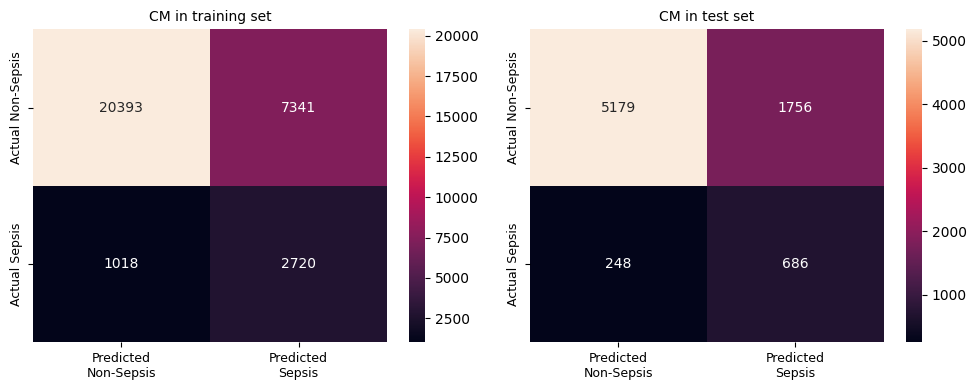

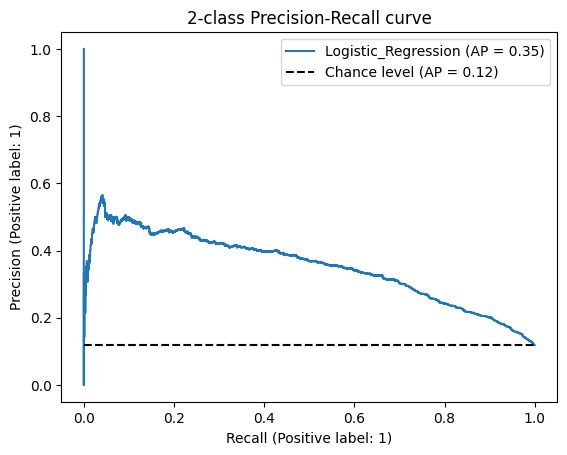

Logistic_Regression AUC : 0.8091


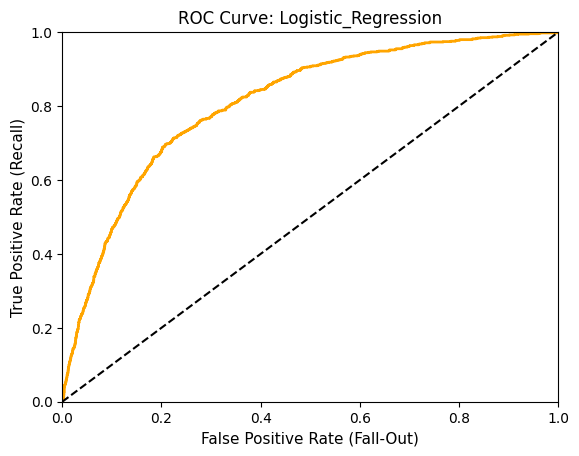

<Figure size 600x600 with 0 Axes>

Random_Forest
 ---------------------------------------- 


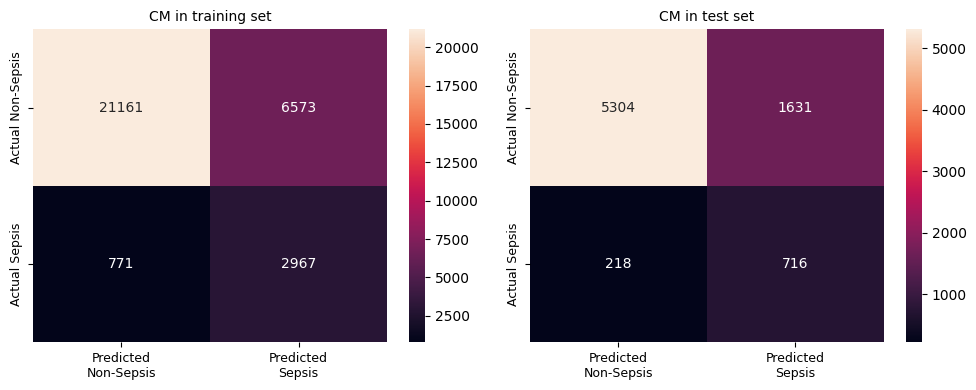

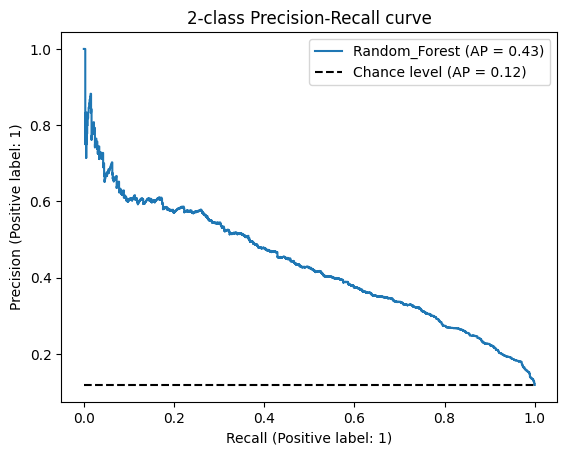

Random_Forest AUC : 0.8413


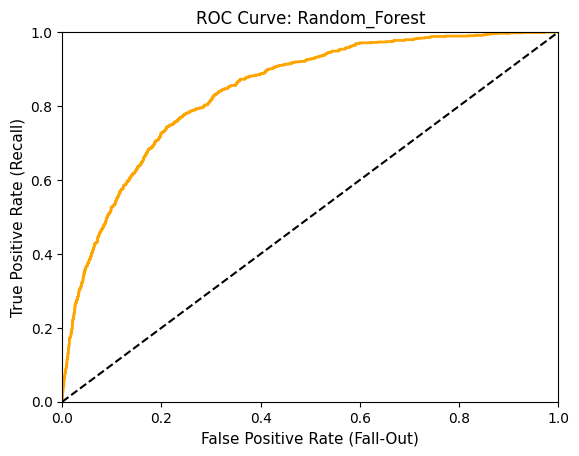

<Figure size 600x600 with 0 Axes>

Gradient_Boosting
 ---------------------------------------- 


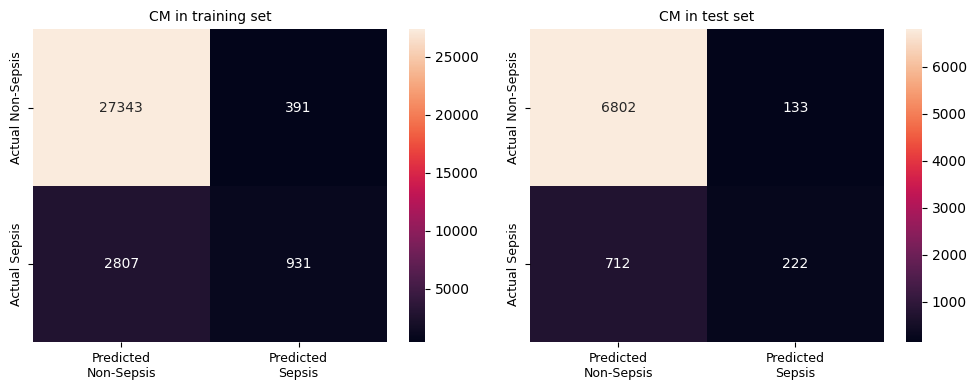

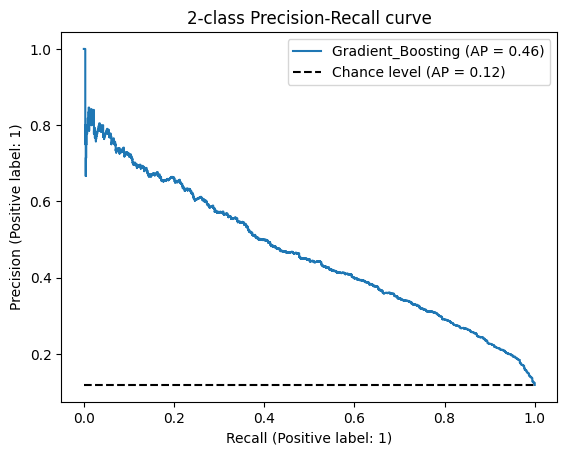

Gradient_Boosting AUC : 0.8492


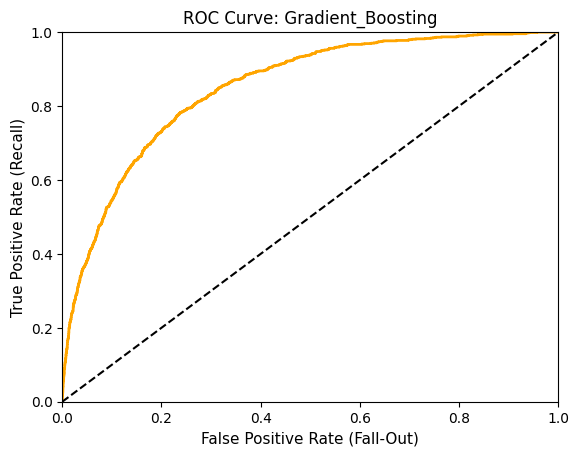

<Figure size 600x600 with 0 Axes>

In [39]:
mp.plot_results(candidate_models, class_weights, X_t3_train, X_t3_test, y_t3_train, y_t3_test)

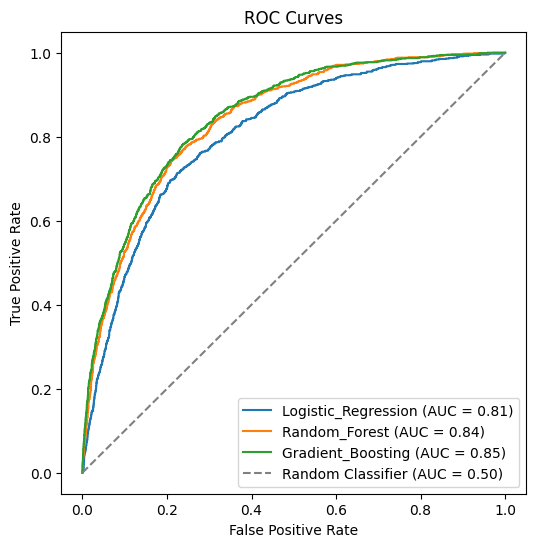

In [40]:
mp.plot_combined_roc_curves(candidate_models, X_t3_test, y_t3_test)

# 7. Feature Importance

### 7.1 SHAP

In [41]:
target_column = ["IS_SEPSIS"]
feature_columns = dfs_dict_without_missing['top40']['t3'].columns.drop("IS_SEPSIS").tolist()

# Convert 'ITEMID_' column to title
itemid_columns = [col for col in feature_columns if col.startswith('ITEMID_')]
title_mapping = dataLoader.convert_itemid_to_title(itemid_columns, df_desc_labitems)
for itemid, title in title_mapping.items():
    feature_columns[feature_columns.index(itemid)] = title

In [76]:
# Convert numpy array back to DataFrame
X_t3_train_df = pd.DataFrame(X_t3_train, columns=feature_columns)
y_t3_train_df = pd.DataFrame(y_t3_train, columns=target_column)
y_t3_train_df = y_t3_train_df.reset_index(drop=True)


X_t3_test_df = pd.DataFrame(X_t3_test, columns=feature_columns)
y_t3_test_df = pd.DataFrame(y_t3_test, columns=target_column)
y_t3_test_df = y_t3_test_df.reset_index(drop=True)

#### 7.1.1 Logistic Regression

##### 7.1.1.1 Global feature importance

In [44]:
explainer_lr = shap.LinearExplainer(candidate_models['Logistic_Regression'], X_t3_train_df)
shap_values_lr = explainer_lr(X_t3_test_df)

# set a display version of the data to use for plotting (has string values)
shap_values_lr.display_data = shap.datasets.adult(display=True)[0].values

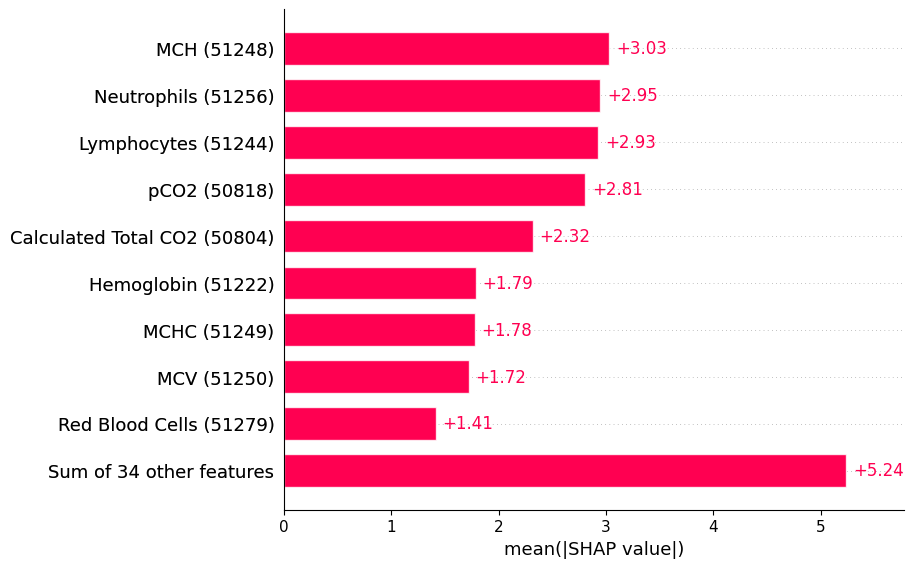

In [45]:
shap.plots.bar(shap_values_lr)

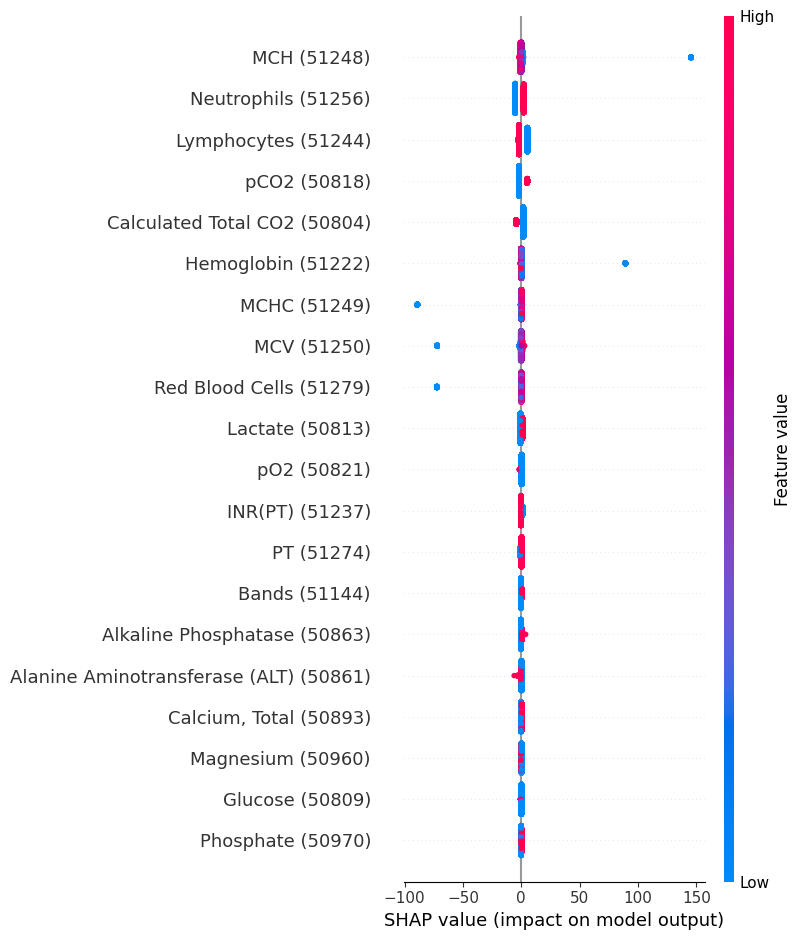

In [46]:
shap.summary_plot(shap_values_lr, X_t3_test_df)

This plot shows the impact of each feature on the model output, as measured by SHAP value. The features are sorted from highest to lowest impact, so the most important features are at the top. The color of each bar indicates the impact on the model output, with red bars representing positive impacts and blue bars representing negative impacts.

- Positive impact: A feature has a positive impact on the model output if it increases the predicted value of the model.
- Negative impact: A feature has a negative impact on the model output if it decreases the predicted value of the model.

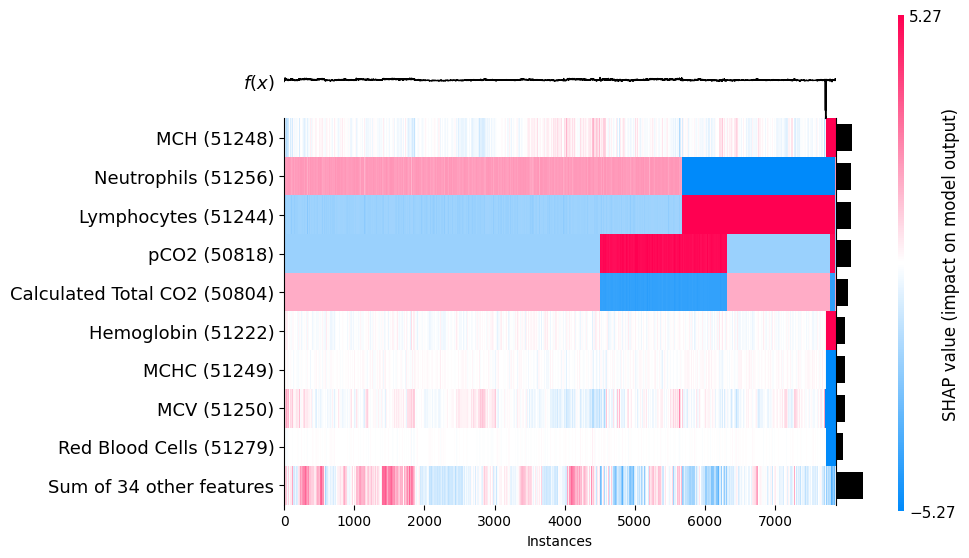

In [130]:
shap.plots.heatmap(shap_values_lr[:])

##### 7.1.1.2 Local Feature Importance

Sepsis Admission

In [82]:
# This will return a Series of boolean values (True where the condition is met, False otherwise)
condition = y_t3_test_df['IS_SEPSIS'] == 1

# Display the indices where the condition is met
positive_indices = y_t3_test_df[condition].index
print(positive_indices)

Index([  16,   20,   34,   49,   52,   57,   68,   69,   77,   81,
       ...
       7754, 7761, 7763, 7765, 7792, 7799, 7800, 7818, 7839, 7852],
      dtype='int64', length=934)


In [85]:
true_label_instance_1 = y_t3_test_df.iloc[16]
print(true_label_instance_1)

IS_SEPSIS    1
Name: 16, dtype: int64


In [133]:
#16
individual_instance_1 = X_t3_test_df.loc[[16]]
shap_values_lr_ind_1 = explainer_lr(individual_instance_1)
shap.initjs()
shap.force_plot(shap_values_lr_ind_1)

In [ ]:
true_label_instance_2 = y_t3_test_df.iloc[7839]
print(true_label_instance_2)

IS_SEPSIS    1
Name: 7839, dtype: int64


In [135]:
individual_instance_2 = X_t3_test_df.loc[[7839]]
shap_values_lr_ind_2 = explainer_lr(individual_instance_2)
shap.initjs()
shap.force_plot(shap_values_lr_ind_2)

Non-Sepsis Admission

In [ ]:
true_label_instance_3 = y_t3_test_df.iloc[2633]
print(true_label_instance_3)

IS_SEPSIS    0
Name: 27592, dtype: int64


In [136]:
individual_instance_3 = X_t3_test_df.loc[[2633]]
shap_values_lr_ind_3 = explainer_lr(individual_instance_3)
shap.initjs()
shap.force_plot(shap_values_lr_ind_3)

In [ ]:
true_label_instance_4 = y_t3_test_df.iloc[522]
print(true_label_instance_4)

IS_SEPSIS    0
Name: 33157, dtype: int64


In [137]:
individual_instance_4 = X_t3_test_df.loc[[522]]
shap_values_lr_ind_4 = explainer_lr(individual_instance_4)
shap.initjs()
shap.force_plot(shap_values_lr_ind_4)

#### 7.1.2 Random Forest

##### 7.1.2.1 Global Feature Importance

In [104]:
explainer_rf = shap.TreeExplainer(candidate_models['Random_Forest']) 
shap_values_rf = explainer_rf.shap_values(X_t3_test_df) 

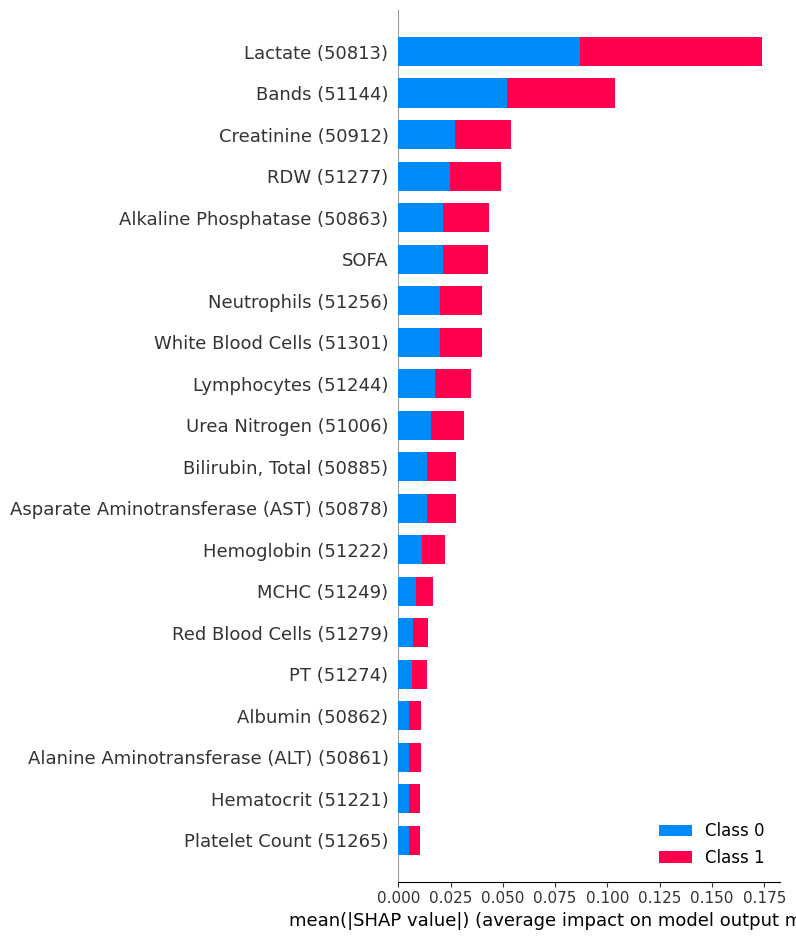

In [105]:
shap.summary_plot(shap_values_rf, X_t3_test_df)

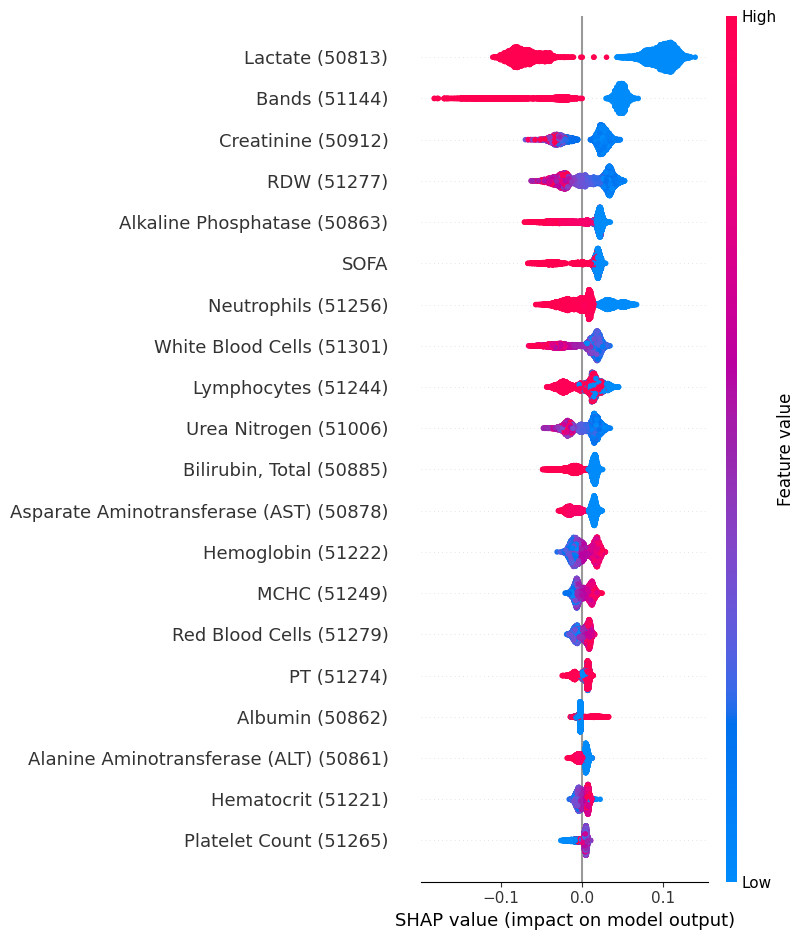

In [106]:
shap.summary_plot(shap_values_rf[0], X_t3_test_df)

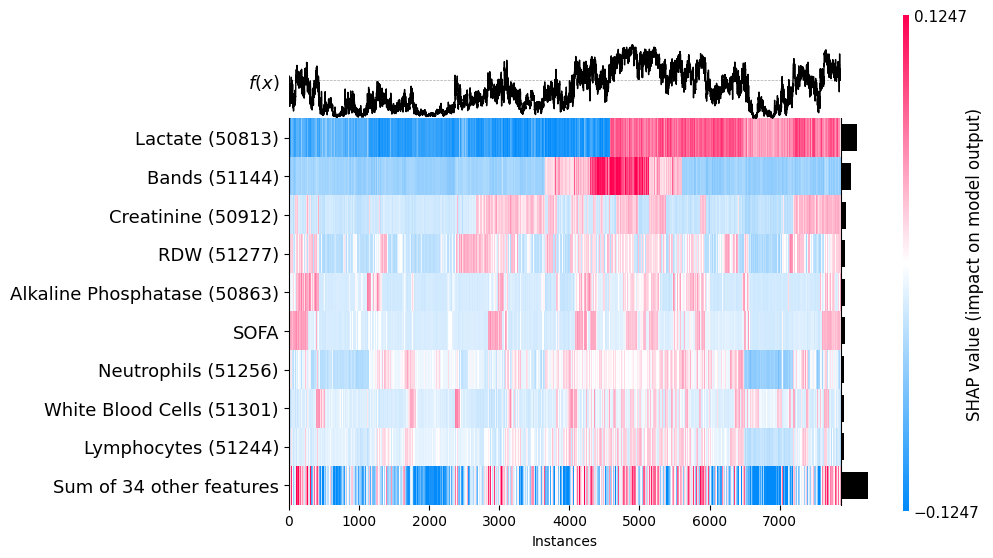

In [129]:
shap_values_rf_subset = explainer_rf(X_t3_test_df.iloc[:])
shap.plots.heatmap(shap_values_rf_subset[:, :, 1])

##### 7.1.2.2 Local Feature Importance

Sepsis Admission

In [86]:
shap_values_rf_ind_1 = explainer_rf.shap_values(individual_instance_1)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_1[1], individual_instance_1)

In [88]:
individual_instance_2 = X_t3_test_df.loc[[7839]]
shap_values_rf_ind_2 = explainer_rf.shap_values(individual_instance_2)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_2[1], individual_instance_2)

Non-spesis Admission

In [59]:
individual_instance_3 = X_t3_test_df.loc[[2633]]
shap_values_rf_ind_3 = explainer_rf.shap_values(individual_instance_3)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_3[1], individual_instance_3)

In [90]:
individual_instance_4 = X_t3_test_df.loc[[522]]
shap_values_rf_ind_4 = explainer_rf.shap_values(individual_instance_4)
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf_ind_4[1], individual_instance_4)

#### 7.1.3 Gradient Boosting

##### 7.1.3.1 Global Feature Importance

In [100]:
# compute SHAP values
explainer_gb = shap.TreeExplainer(candidate_models['Gradient_Boosting'])
shap_values_gb = explainer_gb(X_t3_test_df)

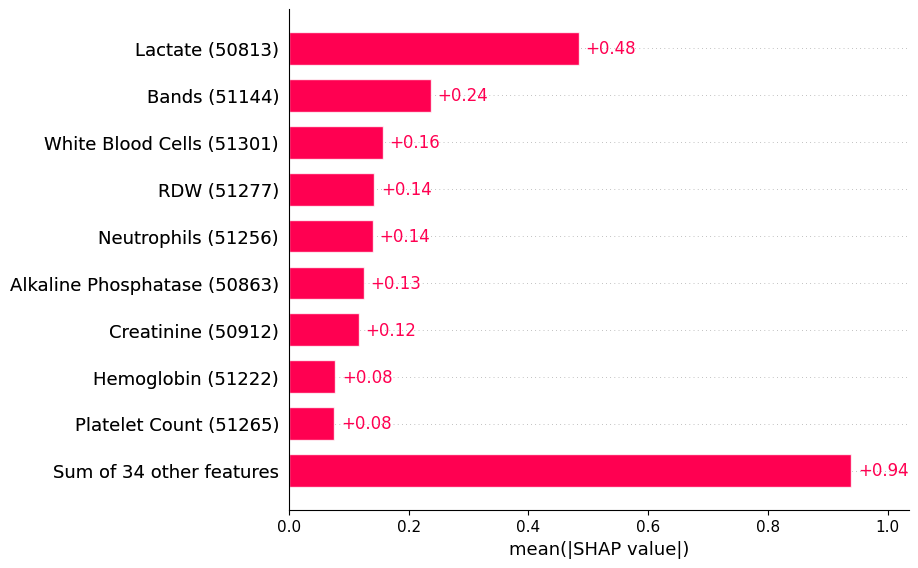

In [98]:
shap.plots.bar(shap_values_gb)

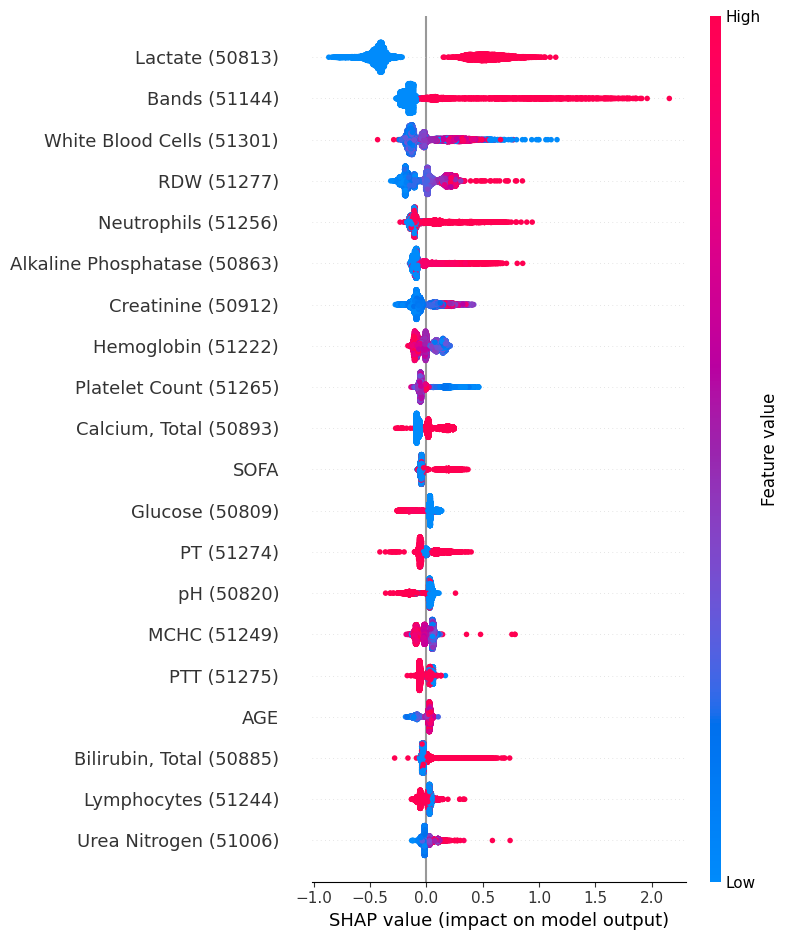

In [99]:
shap.summary_plot(shap_values_gb, X_t3_test_df)

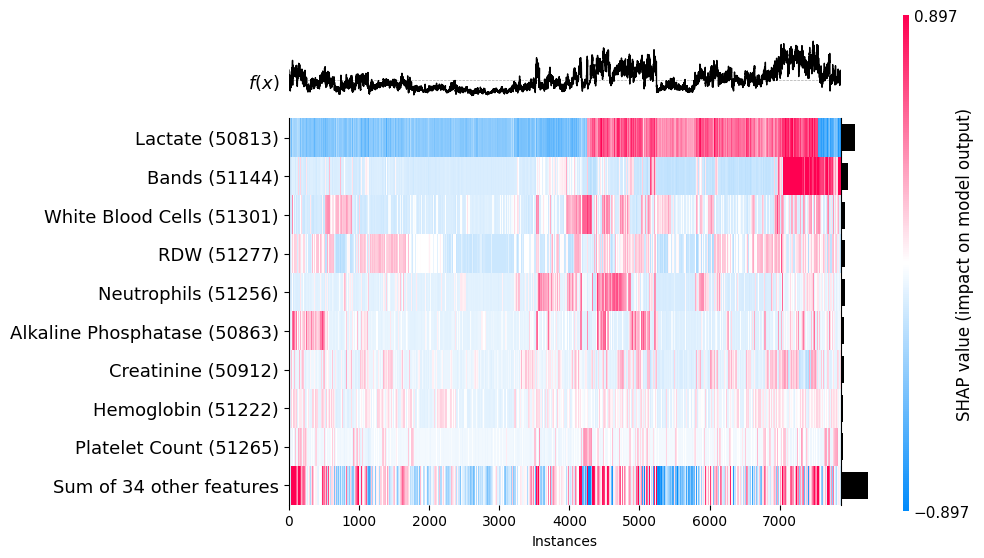

In [125]:
shap.plots.heatmap(shap_values_gb[:])

##### 7.1.3.2 Local Feature Importance

Sepsis Admission

In [112]:
#16
shap_values_gb_ind_1 = explainer_gb(individual_instance_1)
shap.initjs()
shap.force_plot(shap_values_gb_ind_1)

In [113]:
#7839
shap_values_gb_ind_2 = explainer_gb(individual_instance_2)
shap.initjs()
shap.force_plot(shap_values_gb_ind_2)

Non-Sepsis Admission

In [115]:
#2633
shap_values_gb_ind_3 = explainer_gb(individual_instance_3)
shap.initjs()
shap.force_plot(shap_values_gb_ind_3)

In [116]:
#522
shap_values_gb_ind_4 = explainer_gb(individual_instance_4)
shap.initjs()
shap.force_plot(shap_values_gb_ind_4)

# 8. Tuning Hyperparameters

From the above model evaluation, we have found Random Forest model performs the best among the 3 Traditional ML models. In this section, we will try to tune some of its hyperparameters in order to further improve its performance.

In [142]:
best_params_rf = mp.tune_hyperparameters_rf(X_t3_train, y_t3_train, class_weights, candidate_models['Random_Forest'])

Best parameters: {'max_depth': 20, 'min_samples_leaf': 50, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.7577


In [143]:
rf_best = RandomForestClassifier(random_state=901,class_weight=class_weights, max_depth= 20, min_samples_leaf=50, min_samples_split=2, n_estimators=100)
rf_best.fit(X_t3_train, y_t3_train)

RandomForestClassifier(class_weight={0: 1.1341, 1: 8.4563}, max_depth=20,
                       min_samples_leaf=50, random_state=901)

In [144]:
mp.validate_test_groundtruth(rf_best, X_t3_test, y_t3_test)



For test data generated using train test split 

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      6935
           1       0.33      0.72      0.45       934

    accuracy                           0.79      7869
   macro avg       0.64      0.76      0.66      7869
weighted avg       0.88      0.79      0.82      7869

Cohen_kappa_score: 0.3419241300587478 


In [145]:
final_model = {
    'Random_Forest': RandomForestClassifier(random_state=901,class_weight=class_weights, max_depth= 20, min_samples_leaf=50, min_samples_split=2, n_estimators=100),
    }

In [146]:
performance_df_final = mp.static_models(final_model, class_weights, X_t3_train, y_t3_train, X_t3_test, y_t3_test, time = 't3')
performance_df_final

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Model  Balanced_Acc_Train  Balanced_Acc_Test  Precision_Train  \
0  Random_Forest_t3            0.815281           0.761482         0.361849   

   Precision_Test  Recall_Train  Recall_Test  F1_Train   F1_Test  
0        0.325951       0.82718     0.724839   0.50346  0.449684

Random_Forest
 ---------------------------------------- 


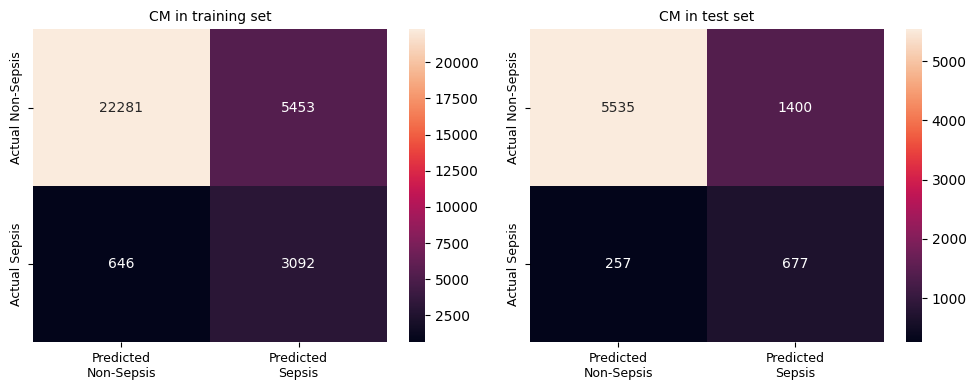

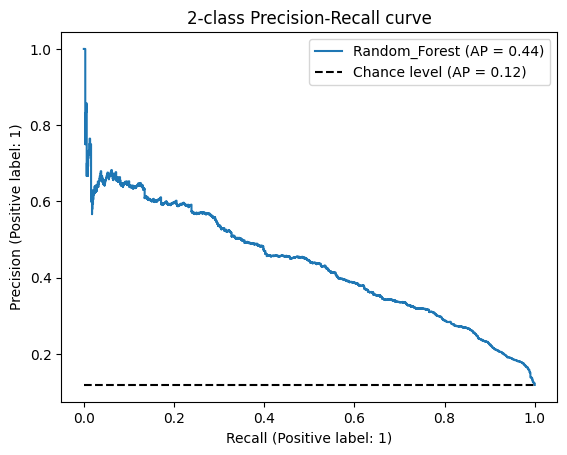

Random_Forest AUC : 0.8449


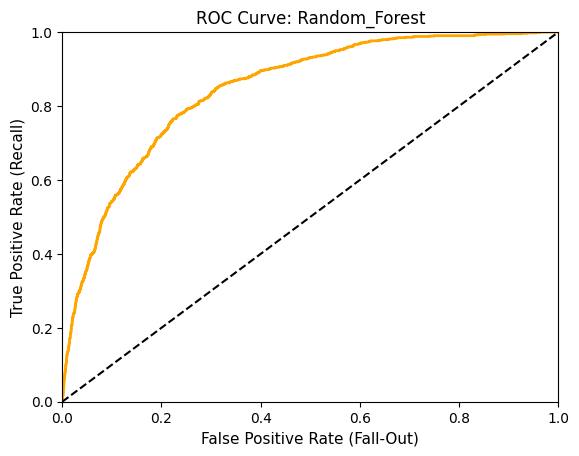

<Figure size 600x600 with 0 Axes>

In [147]:
mp.plot_results(final_model, class_weights, X_t3_train, X_t3_test, y_t3_train, y_t3_test)